In [1]:
# Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
import pandas_ta as ta
import seaborn as sns
import yfinance as yf
import requests
from io import StringIO

In [2]:
#Set the fiat currency pair
from_symbol = "EUR"
to_symbol = "USD"
interval = "60min"
api_key = "CV4O3KUIMS9TVCLR"

In [3]:
# Load the data from the API
url = f"https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol={from_symbol}&to_symbol={to_symbol}&interval={interval}&apikey={api_key}&datatype=csv"
request = requests.get(url)

In [4]:
#Convert the CSV to a pandas dataframe
data = StringIO(request.text)
csv_res_df = pd.read_csv(data)

In [5]:
# Convert to DataFrame
data_df = csv_res_df.copy()
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])
pricing_df = data_df.set_index('timestamp')
pricing_df.sort_index(ascending=True, inplace=True)

In [6]:
# Declare the variables that will be used globally as SMA window, Short Period and Long Period / Standard Deviation
# length / short period - The SMA window
# std / long period - The standard deviation

sma_window = 20
std = 2

In [7]:
pricing_df.ta.bbands(close = 'close', length = sma_window, std= std, append = True)

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
timestamp,,,,,
2023-10-05 09:00:00,NaN,NaN,NaN,NaN,NaN
2023-10-05 10:00:00,NaN,NaN,NaN,NaN,NaN
2023-10-05 11:00:00,NaN,NaN,NaN,NaN,NaN
2023-10-05 12:00:00,NaN,NaN,NaN,NaN,NaN
2023-10-05 13:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-10-11 09:00:00,1.059264,1.060478,1.061693,0.228973,0.652993
2023-10-11 10:00:00,1.059416,1.060529,1.061643,0.209987,0.459811
2023-10-11 11:00:00,1.059489,1.060553,1.061616,0.200563,0.324877


In [8]:
#Create f strings for the column names
str_upper_band = f"BBU_{sma_window}_{std}.0"
str_middle_band = f"BBM_{sma_window}_{std}.0"
str_lower_band = f"BBL_{sma_window}_{std}.0"

# Generate the trading signals
# 1 Represents a buy
# -1 represents a sell
# 0 represents a hold
bands_signal = []
signal = 0

for i in range(len(pricing_df['close'])):
    # Today's price is below the lower band
    # The price has dropped below the bands and a rise is expected
    # We want to buy
     
    if pricing_df['close'][i] < pricing_df[str_lower_band][i]:
        # If we are not already in a buy position
        # Add today's price to the buy list
        # Update the signal to show we are in buy
        # Enter long position
        signal = 1
        entry_price = pricing_df['close'][i]
        bands_signal.append(signal)

    # Today's price is above the upper band
    # The price has increased above the bands and a drop is expected
    # We want to sell
    elif pricing_df['close'][i] > pricing_df[str_upper_band][i]:

        # If we are not already in a sell position
        # Add today's price to the sell list
        # Update the signal to show we are in sell
        # Enter short position
        signal = -1
        entry_price = pricing_df['close'][i]
        bands_signal.append(signal)
        
    else:
        signal = 0
        bands_signal.append(signal)

#Create positions for our strategy
position = []
for i in range(len(bands_signal)):
    if bands_signal[i] == 1:
        position.append(1)
    else:
        position.append(0)

for i in range(len(pricing_df['close'])):
    # If we are in a buy position, set our position as buy
    if bands_signal[i] == 1:
        position[i] = 1
    # If we are in a sell position, set our position as sell
    elif bands_signal[i] == -1:
        position[i] = 0
    # Otherwise use yesterday's position
    else:
        position[i] = position[i-1]

In [9]:
plt_df = pricing_df.copy().dropna()

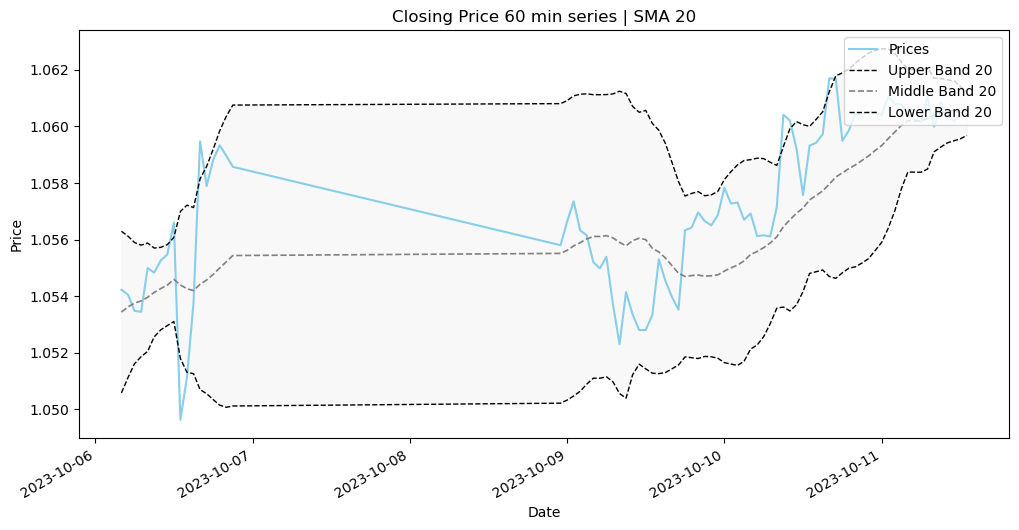

In [10]:
plt.figure(figsize = (12,6))
plt.title("Closing Price 60 min series | SMA "+str(sma_window))
plt_df['close'].plot(label = 'Prices', color = 'skyblue')
plt_df[str_upper_band].plot(label = 'Upper Band '+str(sma_window), linestyle = '--', linewidth = 1, color = 'black')
plt_df[str_middle_band].plot(label = 'Middle Band '+str(sma_window), linestyle = '--', linewidth = 1.2, color = 'grey')
plt_df[str_lower_band].plot(label = 'Lower Band '+str(sma_window), linestyle = '--', linewidth = 1, color = 'black')
plt.fill_between(pricing_df.index, pricing_df[str_lower_band],pricing_df[str_upper_band], color='grey', alpha = 0.05)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.show()

In [550]:
count_neg = 0
count_pos = 0
count_zel = 0

for i in bands_signal:
    if i == -1:
        count_neg+= 1
    elif i == 1:
        count_pos+=1
    else:
        count_zel+=1
print(count_neg)
print(count_pos)
print(count_zel)

6
2
92


In [551]:
#Create a copy of the main dataset
main_df_new = pricing_df.copy()

#Add the bands_signal list to the main dataset
main_df_new['Signal'] = bands_signal

#Add the positions list to the main dataset
main_df_new['Position'] = position

#Calculate Returns and Cummulative Returns and append to the DataFrame
#New column name is LOGRET_1
main_df_new.ta.log_return(close='close', append=True)

#New column name is CUMLOGRET_1
main_df_new.ta.log_return(close='close',cumulative=True, append=True)

timestamp
2023-10-04 10:00:00    0.000000
2023-10-04 11:00:00    0.000457
2023-10-04 12:00:00   -0.000019
2023-10-04 13:00:00    0.002559
2023-10-04 14:00:00    0.000847
                         ...   
2023-10-10 10:00:00    0.009839
2023-10-10 11:00:00    0.008905
2023-10-10 12:00:00    0.007346
2023-10-10 13:00:00    0.008999
2023-10-10 14:00:00    0.008716
Name: CUMLOGRET_1, Length: 100, dtype: float64

In [552]:
#Calculate the performance on the strategy data
main_df_new['Strategy'] = main_df_new['Position'] * main_df_new['LOGRET_1']
main_df_new['Cummulative Strategy'] = main_df_new['Strategy'].cumsum()

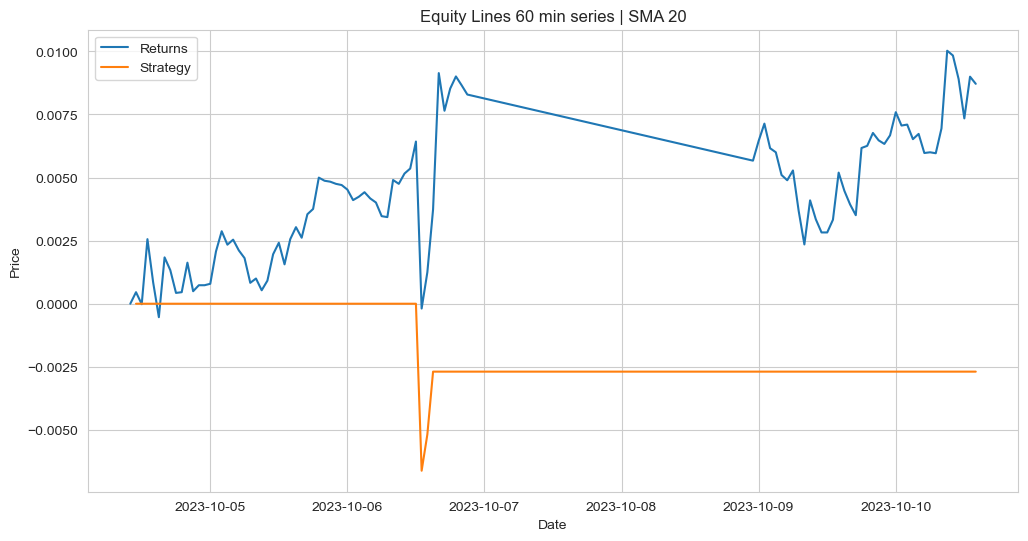

In [553]:
#Plot the figures with the trading signals
plt.figure(figsize = (12,6))
plt.title("Equity Lines 60 min series | SMA "+str(sma_window))
plt.plot(main_df_new['CUMLOGRET_1'], label = "Returns")
plt.plot(main_df_new['Cummulative Strategy'], label = "Strategy")
plt.xlabel("Date")
plt.ylabel("Price")
sns.set_style("whitegrid")
plt.legend(loc='upper left')
plt.show()

### Get Profit and Loss

In [554]:
contract = 100
fees = 0.01

In [570]:
rpnl_list = [] 
realized_dates = []

#Calculate the profit and loss of the strategy
for i in range(len(pricing_df['close'])):
    
    # If we are in a buy/long position
    if position[i] == 1:
        #pnl = (contract * pricing_df['close'][i]) - (contract * pricing_df['open'][i]) - fees
        pnl = pricing_df['close'][i] - pricing_df['open'][i]
        realized_dates.append(pricing_df.index[i])
        rpnl_list.append(pnl)
        
    # If we are in a sell/short position+
    elif position[i] == 0:
        #pnl = (contract * pricing_df['close'][i]) - (contract * pricing_df['open'][i]) - fees
        pnl = pricing_df['open'][i] - pricing_df['close'][i]
        realized_dates.append(pricing_df.index[i])
        rpnl_list.append(pnl)
        

### Run backtest

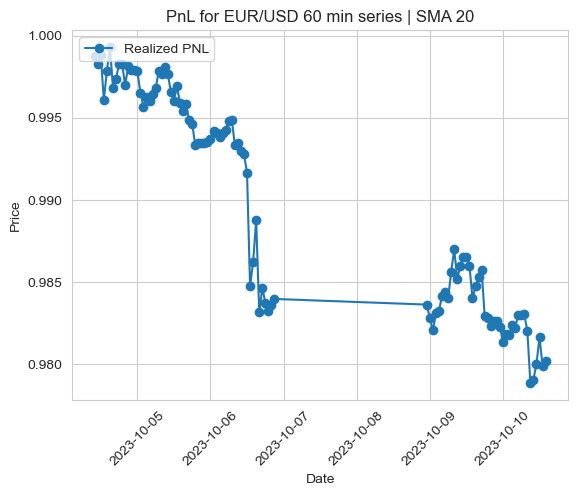

In [572]:
#Plot the figures with the trading signals
plt.title(f"PnL for {from_symbol}/{to_symbol} 60 min series | SMA "+str(sma_window))
plt.plot(realized_dates, np.cumprod(1 + np.array(rpnl_list)), label = "Realized PNL", marker='o')
#plt.plot(realized_dates, np.cumsum(rpnl_list), label = "Realized PNL", marker='o')
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation = 45)
sns.set_style("whitegrid")
plt.legend(loc='upper left')
plt.show()

In [581]:
perchange = ((np.asarray(main_df_new['LOGRET_1'])).reshape(10,10))

In [584]:
# Create an array to annotate the heatmap
labels = (np.asarray(["{0} \n {1:.2f}".format(value)
                      for value in zip(perchange.flatten())])
         ).reshape(10,10)

IndexError: Replacement index 1 out of range for positional args tuple

IndexError: Inconsistent shape between the condition and the input (got (100, 1) and (100,))

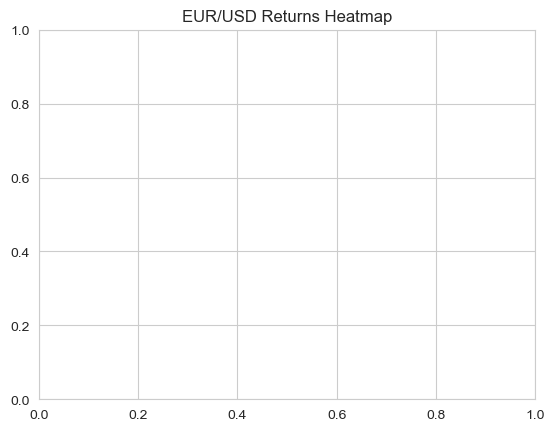

In [582]:
#Plot the figures with the trading signals
plt.title(f"{from_symbol}/{to_symbol} Returns Heatmap")
sns.heatmap(main_df_new['LOGRET_1'], cmap="YlGnBu", annot=True);
plt.show()